In [36]:
#install torch
%pip install torch==2.2.0 torchvision torchaudio


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


^C
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.10/site-packages/pip/__main__.py", line 24, in <module>
    sys.exit(_main())
  File "/opt/conda/lib/python3.10/site-packages/pip/_internal/cli/main.py", line 79, in main
    return command.main(cmd_args)
  File "/opt/conda/lib/python3.10/site-packages/pip/_internal/cli/base_command.py", line 101, in main
    return self._main(args)
  File "/opt/conda/lib/python3.10/site-packages/pip/_internal/cli/base_command.py", line 114, in _main
    options, args = self.parse_args(args)
  File "/opt/conda/lib/python3.10/site-packages/pip/_internal/cli/base_command.py", line 96, in parse_args
    return self.parser.parse_args(args)
  File "/opt/conda/lib/python3.10/optparse.py", line 1371, in parse_args
    values 

In [1]:
import json
import torch
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizer, RobertaModel, RobertaConfig
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import f1_score
from tqdm import tqdm, trange

In [2]:
train = json.load(open('/kaggle/input/data-json/train_file.json'))
test = json.load(open('/kaggle/input/data-json/val_file.json'))

print('train:', len(train))
print('test:', len(test))

train: 6740
test: 843


## BERT ENCODINGS

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  


## DATALOADERS

# Convert json to csv

In [4]:
dialogue_ids = []
speaker = []
emotion = []
utterance = []
erf_label = []

for i in range(len(train)):
    dialogue_ids.append(train[i]['episode'])
    speaker.append(train[i]['speakers'])
    emotion.append(train[i]['emotions'])
    utterance.append(train[i]['utterances'])
    erf_label.append(train[i]['triggers'])
df_train = pd.DataFrame(list(zip(dialogue_ids, speaker, emotion, utterance, erf_label)), columns =['Dialogue_ID', 'Speaker', 'Emotion', 'Utterance', 'ERF_Label'])
# save this dataframe to a csv file
df_train.to_csv('train.csv', index=False)
dialogue_ids = []
speaker = []
emotion = []
utterance = []
erf_label = []

for i in range(len(test)):
    dialogue_ids.append(train[i]['episode'])
    speaker.append(train[i]['speakers'])
    emotion.append(train[i]['emotions'])
    utterance.append(train[i]['utterances'])
    erf_label.append(train[i]['triggers'])
df_test = pd.DataFrame(list(zip(dialogue_ids, speaker, emotion, utterance, erf_label)), columns =['Dialogue_ID', 'Speaker', 'Emotion', 'Utterance', 'ERF_Label'])
# save this dataframe to a csv file
df_test.to_csv('test.csv', index=False)


In [5]:
df_train.head()

,Dialogue_ID,Speaker,Emotion,Utterance,ERF_Label
0,utterance_3492,"[Phoebe, Eric, Phoebe, Eric, Phoebe]","[surprise, fear, surprise, sadness, disgust]","[You-you you had sex with Ursula?!, Uh, a litt...","[1.0, 1.0, 0.0, 0.0, 0.0]"
1,utterance_3952,"[Monica, Monica, Phoebe, Joey, Joey, Joey, Rac...","[disgust, disgust, anger, sadness, surprise, a...","[Dad, please don't pick your teeth out here!, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,utterance_3198,"[Older Scientist, Ross, Ross, Joey, Ross, Ross...","[neutral, neutral, neutral, neutral, neutral, ...","[Dr. Geller, there's a seat over here., Thank ...","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]"
3,utterance_2834,"[Monica, Monica, Monica]","[neutral, surprise, neutral]","[So, how'd the lasagne go over?, Really?!, Good.]","[0.0, 0.0, 1.0]"
4,utterance_453,"[Kate, The Director, Kate]","[joy, sadness, sadness]","[Become a drama critic!, I am hurt! A plague ...","[0.0, 0.0, 1.0]"


In [6]:
df_test.head()

,Dialogue_ID,Speaker,Emotion,Utterance,ERF_Label
0,utterance_3492,"[Phoebe, Eric, Phoebe, Eric, Phoebe]","[surprise, fear, surprise, sadness, disgust]","[You-you you had sex with Ursula?!, Uh, a litt...","[1.0, 1.0, 0.0, 0.0, 0.0]"
1,utterance_3952,"[Monica, Monica, Phoebe, Joey, Joey, Joey, Rac...","[disgust, disgust, anger, sadness, surprise, a...","[Dad, please don't pick your teeth out here!, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,utterance_3198,"[Older Scientist, Ross, Ross, Joey, Ross, Ross...","[neutral, neutral, neutral, neutral, neutral, ...","[Dr. Geller, there's a seat over here., Thank ...","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]"
3,utterance_2834,"[Monica, Monica, Monica]","[neutral, surprise, neutral]","[So, how'd the lasagne go over?, Really?!, Good.]","[0.0, 0.0, 1.0]"
4,utterance_453,"[Kate, The Director, Kate]","[joy, sadness, sadness]","[Become a drama critic!, I am hurt! A plague ...","[0.0, 0.0, 1.0]"


In [7]:
unicode_mapping = {}
unicode_mapping['\x85'] = '...' 
unicode_mapping['\x91'] = "'"
unicode_mapping['\x92'] = "'"
unicode_mapping['\x93'] = '"'
unicode_mapping['\x94'] = '"'
unicode_mapping['\x97'] = '--'

unicode_mapping['\u2014'] = '--'
unicode_mapping['\u2019'] = "'"
unicode_mapping['\u2026'] = '...'

unicode_mapping['\xe9'] = 'e'

def clean_utterance(utterance_list):
    '''	
    This function takes a list of utterances and replaces the unicode with the proper characters.
    '''
    cleaned_utterances_list = []
    for utterance in utterance_list:
        for key in unicode_mapping:
            utterance = utterance.replace(key, unicode_mapping[key])
        cleaned_utterances_list.append(utterance)
    return cleaned_utterances_list

train_uttr = df_train['Utterance'].apply(lambda x: clean_utterance(x))
df_train['Utterance'] = train_uttr
test_uttr = df_test['Utterance'].apply(lambda x: clean_utterance(x))
df_test['Utterance'] = test_uttr
for i in range(len(df_train)):
    for j in range(len(df_train['ERF_Label'][i])):
        if df_train['ERF_Label'][i][j] != 1.0 and df_train['ERF_Label'][i][j] != 0.0:
            df_train['ERF_Label'][i][j] = 0.0
    
    # for j in range(len(df_test['ERF_Label'][i])):
    #     if df_test['ERF_Label'][i][j] == 'None':
    #         df_test['ERF_Label'][i][j] = -1

for i in range(len(df_test)):
    for j in range(len(df_test['ERF_Label'][i])):
        if df_test['ERF_Label'][i][j] != 1.0 and df_test['ERF_Label'][i][j] != 0.0:
            df_test['ERF_Label'][i][j] = 0.0

In [8]:
print(df_train['Utterance'][0])

['You-you...you had sex with Ursula?!', 'Uh, a little bit. She-she-she walked in and I thought she was you and I kissed her and', "You didn't notice she was wearing different clothes?!", 'Well I was just so excited to see you.', "Oh. Ew! Ew! Ew! Ugh! Y'know what? This is too weird."]


In [9]:
# max length episode
max_len = 0
for i in range(len(df_train)):
    max_len = max(max_len, len(df_train['Utterance'][i]))
print(max_len)

24


In [10]:
from transformers import RobertaTokenizer, RobertaModel, RobertaConfig
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn


tokenizer = AutoTokenizer.from_pretrained("roberta-base")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [50]:
class Model(nn.Module):
    #model consists of a EmoBERTa model and a linear layer for sequence labeling task
    def __init__(self, num_classes=2):
        super(Model, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.fc = nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids, attention_mask)
        out = outputs[0]
        out = out[:, 0, :]
        out = self.fc(out)
        # make sure output is either 0 or 1
        out = torch.sigmoid(out)
#         out = torch.round(out)
        return out
class Dataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = self.process(data, tokenizer)
        self.max_len = max_len

    def __len__(self):
        return len(self.data['input'])

    def __getitem__(self, index):
        #tokenize the input
        input = self.data['input'][index]
        target = self.data['target'][index]
#         if target == 'None':
#             target = -1
#         print(target)
        encoding = self.tokenizer(input, return_tensors='pt', padding='max_length', max_length=self.max_len, truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'target':torch.tensor(target)}
        
    def process(self, data, tokenizer):
        new_data = {'input': [], 'target': []}
        for i in range(len(data)):
            newinput = data.loc[i].copy()
            stringlist = []
            for j in range(len(newinput['Utterance'])):
                stringlist.append(newinput['Speaker'][j] + ': ' + newinput['Utterance'][j] + ":" + newinput['Emotion'][j])
            for j in range(len(newinput['Utterance'])):
                #join till jth utterance
                temp = ' '.join(stringlist[:j])
                temp += '</s></s>'
                #add jth utterance
                temp += newinput['Speaker'][j] + ': ' + newinput['Utterance'][j] + ":" + newinput['Emotion'][j]
                temp += '</s></s>'
                #add later Utterence
                temp += ' '.join(stringlist[j+1:])
                temp = '<s> ' + temp + '</s>'
                new_data['input'].append(temp)
                target = newinput['ERF_Label'][j]
                # print(target)
                new_data['target'].append(target)
        return new_data
            
    

In [51]:
def collate_fn(batch):
    input_ids = []
    attention_mask = []
    target = []
    for b in batch:
        input_ids.append(b['input_ids'])
        attention_mask.append(b['attention_mask'])
        target.append(b['target'])
    input_ids = torch.stack(input_ids)
    attention_mask = torch.stack(attention_mask)
    target = torch.stack(target)
    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'target': target}

In [52]:
# take 10 samples only
# df_train = df_train[:200]
# df_test = df_test[:200]

train_Dataset = Dataset(df_train, tokenizer, 2)
train_loader = DataLoader(train_Dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

test_Dataset = Dataset(df_test, tokenizer, 2)
test_loader = DataLoader(test_Dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

model = Model(1)
model.to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
print(len(train_loader), len(test_loader))


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1843 229


In [14]:
import wandb
wandb.login(relogin=True)


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [53]:
model_config = {
    'model': 'RoBERTa Task 2',
    'learning_rate': 1e-5,
    'batch_size': 32,
    'optimizer': 'AdamW',
    'loss_function': 'BCE'
}
wandb.init(project='assignment-4', entity='nlp-assignments', config=model_config)


epoch,▁█▁▁█▁█▁█▁█▁█▁█
f1_macro,▄▁▂▂▁█▇▇██▇█▇▇▇
f1_micro,▃▁▂▂▁▇▇▇█▇▆█▆▇▆
f1_weighted,▂▁▂▁▁▇▆▆█▇▆█▆▆▅
train_epoch_loss,█████▁▁▁▁▂▂▁▁▁▁
val_epoch_loss,█████▂▂▂▂▂▂▁▁▁▁
epoch,1
f1_macro,0.40426
f1_micro,0.67857
f1_weighted,0.54863
train_epoch_loss,0.4381


In [54]:
print(device)
def train(model,train_loader,test_loader,criterion,optimizer,num_class,epochs):
    train_losses = []
    test_losses = []
    wandb.define_metric('epoch')
    wandb.define_metric('train_epoch_loss', step_metric='epoch')
    wandb.define_metric('val_epoch_loss', step_metric='epoch')
    wandb.define_metric('f1_micro', step_metric='epoch')
    wandb.define_metric('f1_macro', step_metric='epoch')
    wandb.define_metric('f1_weighted', step_metric='epoch')

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in tqdm(train_loader):
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target = batch['target'].to(device)
            # print(input_ids)
#             print(input_ids.shape, attention_mask.shape, target.shape)
            optimizer.zero_grad()
            output = model(input_ids, attention_mask)
#             output = torch.round(output)
#             print(output[0], target)
            #make output
            # output = output.unsqueeze(0) 
#             print(output.shape, target.shape)
#             loss = criterion(output, target)
            loss = criterion(output.view(-1), target)
#             print(loss.item())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        # break
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}')
        model.eval() 
        test_loss = 0
        
        with torch.no_grad():
            true_labels = []
            predictions = []
            for batch in tqdm(test_loader):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                target = batch['target'].to(device)
                # print(input_ids)
                # print(input_ids.shape, attention_mask.shape, target.shape)
                optimizer.zero_grad()
                output = model(input_ids, attention_mask)
#                 output = torch.round(output)
                # print(output, target)
                #make output
                # output = output.unsqueeze(0) 
                # print(output.shape, target.shape)
                # break 
#                 loss = criterion(output, target)
                loss = criterion(output.view(-1), target)
                output = torch.round(output)
                predictions = torch.cat((output,), dim=0)
                true_labels = torch.cat((target,), dim=0)
#                 print(f1_score(target.detach().cpu().numpy(), output.detach().cpu().numpy(), average='micro'))
                test_loss += loss.item()
            
            f1_micro = f1_score(true_labels.detach().cpu().numpy(), predictions.detach().cpu().numpy(), average='micro')
            f1_macro = f1_score(true_labels.detach().cpu().numpy(), predictions.detach().cpu().numpy(), average='macro')
            f1_weighted = f1_score(true_labels.detach().cpu().numpy(), predictions.detach().cpu().numpy(), average='weighted')
            test_loss /= len(test_loader)
            test_losses.append(test_loss)
            print(f'Epoch {epoch+1}/{epochs}, Test Loss: {test_loss},F1 micro:{f1_micro}, F1 macro:{f1_macro},F1 weighted:{f1_weighted}')
        log_dict = {
        'epoch': epoch,
        'train_epoch_loss': train_loss,
        'val_epoch_loss': test_loss,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted
        }
        wandb.log(log_dict)
    return train_losses,test_losses
            

cuda


In [55]:
train_losses,test_losses = train(model,train_loader,test_loader,criterion,optimizer,1,3)
torch.save(model, "model_m1_task_2.pth")

100%|██████████| 1843/1843 [02:06<00:00, 14.53it/s]


Epoch 1/3, Train Loss: 0.44071115978664505


100%|██████████| 229/229 [00:06<00:00, 34.52it/s]


Epoch 1/3, Test Loss: 0.4452244638745962,F1 micro:0.8571428571428571, F1 macro:0.4615384615384615,F1 weighted:0.7912087912087912


100%|██████████| 1843/1843 [02:07<00:00, 14.46it/s]


Epoch 2/3, Train Loss: 0.43927207001350005


100%|██████████| 229/229 [00:06<00:00, 33.09it/s]


Epoch 2/3, Test Loss: 0.4480933169610636,F1 micro:0.8928571428571429, F1 macro:0.47169811320754723,F1 weighted:0.8423180592991916


100%|██████████| 1843/1843 [02:07<00:00, 14.47it/s]


Epoch 3/3, Train Loss: 0.43845218465306224


100%|██████████| 229/229 [00:06<00:00, 32.78it/s]


Epoch 3/3, Test Loss: 0.4436004656371071,F1 micro:0.8214285714285714, F1 macro:0.45098039215686275,F1 weighted:0.7408963585434174


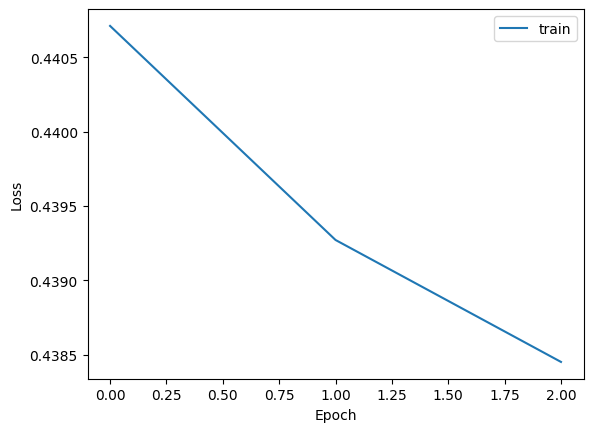

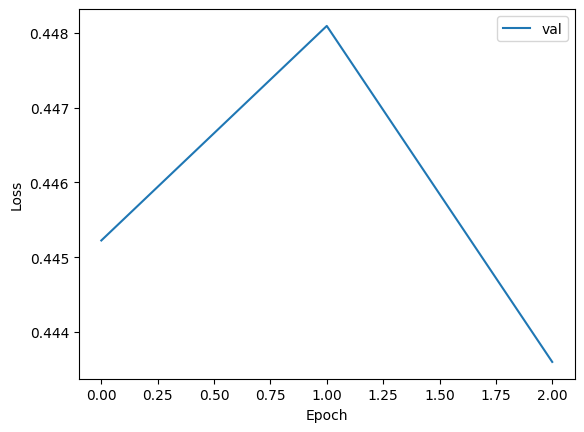

In [56]:
import matplotlib.pyplot as plt
def plot_loss(train_loss,label):
    plt.plot(train_loss, label=label)
#     plt.plot(val_loss, label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
plot_loss(train_losses,'train')
plot_loss(test_losses,'val')

## MODEL 2

In [92]:
import wandb
wandb.login(relogin=True)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [17]:
model_config = {
    'model': 'GRU with Linear Layer',
    'learning_rate': 1e-5,
    'batch_size': 32,
    'optimizer': 'AdamW',
    'loss_function': 'BCELoss'
}
wandb.init(project='assignment-4', entity='nlp-assignments', config=model_config)


In [28]:
class Model2(nn.Module):
    def __init__(self, num_classes):
        super(Model2, self).__init__()
        self.embedding = nn.Embedding(50265, 500)
        self.gru = nn.GRU(500, 500, num_layers=1, batch_first=False, bidirectional=True)
        self.fc = nn.Linear(500*2, num_classes)

    def forward(self, input_ids, attention_mask):
        out = self.embedding(input_ids)
        out, _ = self.gru(out)
        out = out[:, 0, :]
        out = self.fc(out)
        out = torch.sigmoid(out)
#         out = torch.round(out)
        return out

In [47]:
model2 = Model2(1)
model2 = model2.to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model2.parameters(), lr=1e-6)

In [48]:
train_losses,test_losses = train(model2,train_loader,test_loader,criterion,optimizer,1,2)
torch.save(model2, "model_m2_task_2.pth")

100%|██████████| 1843/1843 [00:51<00:00, 35.60it/s]


Epoch 1/2, Train Loss: 0.456234000691951


100%|██████████| 229/229 [00:04<00:00, 49.63it/s]


Epoch 1/2, Test Loss: 0.44436911041299326,F1 micro:0.8214285714285714, F1 macro:0.45098039215686275,F1 weighted:0.7408963585434174


100%|██████████| 1843/1843 [00:51<00:00, 35.55it/s]


Epoch 2/2, Train Loss: 0.4381041274857275


100%|██████████| 229/229 [00:04<00:00, 48.06it/s]


Epoch 2/2, Test Loss: 0.4447034051454744,F1 micro:0.6785714285714286, F1 macro:0.4042553191489362,F1 weighted:0.5486322188449849


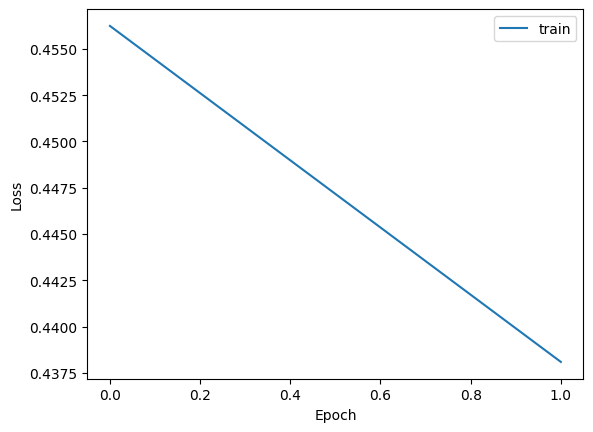

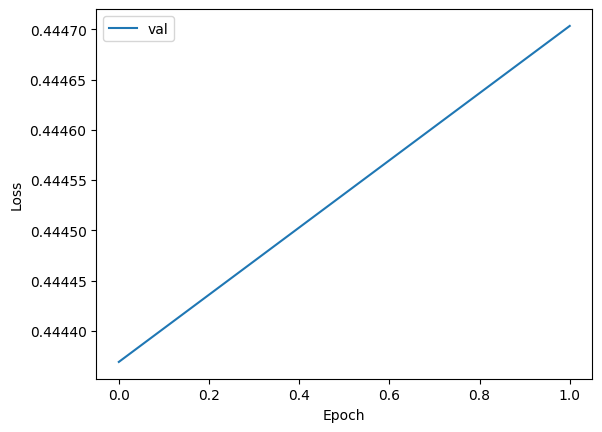

In [49]:
import matplotlib.pyplot as plt
def plot_loss(train_loss,label):
    plt.plot(train_loss, label=label)
#     plt.plot(val_loss, label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
plot_loss(train_losses,'train')
plot_loss(test_losses,'val')

# inference

In [66]:
import pandas as pd
import json
from tqdm import tqdm
test = json.load(open("/kaggle/input/data-json/val_file.json"))

dialogue_ids = []
speaker = []
emotion = []
utterance = []
erf_label = []

for i in range(len(test)):
    dialogue_ids.append(test[i]['episode'])
    speaker.append(test[i]['speakers'])
    emotion.append(test[i]['emotions'])
    utterance.append(test[i]['utterances'])
    erf_label.append(test[i]['triggers'])
df_test = pd.DataFrame(list(zip(dialogue_ids, speaker, emotion, utterance)), columns =['Dialogue_ID', 'Speaker', 'Emotion', 'Utterance'])

unicode_mapping = {}
unicode_mapping['\x85'] = '...' 
unicode_mapping['\x91'] = "'"
unicode_mapping['\x92'] = "'"
unicode_mapping['\x93'] = '"'
unicode_mapping['\x94'] = '"'
unicode_mapping['\x97'] = '--'

unicode_mapping['\u2014'] = '--'
unicode_mapping['\u2019'] = "'"
unicode_mapping['\u2026'] = '...'

unicode_mapping['\xe9'] = 'e'


def clean_utterance(utterance_list):
    '''	
    This function takes a list of utterances and replaces the unicode with the proper characters.
    '''
    cleaned_utterances_list = []
    for utterance in utterance_list:
        for key in unicode_mapping:
            utterance = utterance.replace(key, unicode_mapping[key])
        cleaned_utterances_list.append(utterance)
    return cleaned_utterances_list

test_uttr = df_test['Utterance'].apply(lambda x: clean_utterance(x))
df_test['Utterance'] = test_uttr
# print(df_test.head())


# making the dataloader
from transformers import RobertaTokenizer, RobertaModel, RobertaConfig
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
import torch
# import dataset
from torch.utils.data import Dataset, DataLoader


tokenizer = AutoTokenizer.from_pretrained("roberta-base")
class Dataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = self.process(data, tokenizer)
        self.max_len = max_len

    def __len__(self):
        return len(self.data['input'])

    def __getitem__(self, index):
        #tokenize the input
        input = self.data['input'][index]
#         if target == 'None':
#             target = -1
#         print(target)
        encoding = self.tokenizer(input, return_tensors='pt', padding='max_length', max_length=self.max_len, truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten()}
        
    def process(self, data, tokenizer):
        new_data = {'input': []}
        for i in range(len(data)):
            newinput = data.loc[i].copy()
            stringlist = []
            for j in range(len(newinput['Utterance'])):
                stringlist.append(newinput['Speaker'][j] + ': ' + newinput['Utterance'][j] + ":" + newinput['Emotion'][j])
            for j in range(len(newinput['Utterance'])):
                #join till jth utterance
                temp = ' '.join(stringlist[:j])
                temp += '</s></s>'
                #add jth utterance
                temp += newinput['Speaker'][j] + ': ' + newinput['Utterance'][j] + ":" + newinput['Emotion'][j]
                temp += '</s></s>'
                #add later Utterence
                temp += ' '.join(stringlist[j+1:])
                temp = '<s> ' + temp + '</s>'
                new_data['input'].append(temp)
        return new_data

def collate_fn(batch):
    input_ids = []
    attention_mask = []
    target = []
    for b in batch:
        input_ids.append(b['input_ids'])
        attention_mask.append(b['attention_mask'])
    input_ids = torch.stack(input_ids)
    attention_mask = torch.stack(attention_mask)
    return {'input_ids': input_ids, 'attention_mask': attention_mask}

test_Dataset = Dataset(df_test, tokenizer, 2)
# print(test_Dataset)
test_loader = DataLoader(test_Dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
## MODEL 1
class Model(nn.Module):
    #model consists of a EmoBERTa model and a linear layer for sequence labeling task
    def __init__(self, num_classes=1):
        super(Model, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.fc = nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids, attention_mask)
        out = outputs[0]
        out = out[:, 0, :]
        out = self.fc(out)
        # make sure output is either 0 or 1
        out = torch.sigmoid(out)
#         out = torch.round(out)
        return out
# load model using torch
# model = Model(1)
model = torch.load('/kaggle/input/modelsss/model_m1_task_2.pth')

# Load the state dictionary into the model
# model.load_state_dict(state_dict)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)
# make predictions
predictions = []

for batch in tqdm(test_loader):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    with torch.no_grad():
        output = model(input_ids, attention_mask)
    predictions.append(output)
    
# calculate f1 score
from sklearn.metrics import f1_score
import numpy as np

# convert predictions to numpy array
# predictions = torch.round(predictions)

predictions = [int(i) for i in predictions]
predictions = np.array(predictions)
erf_labels = []
for i in erf_label:
    for j in i:
        if j!=1.0 and j!=0.0:
            erf_labels.append(0.0)
        else:
            erf_labels.append(j)

print(len(erf_labels))


f1_micro = f1_score(predictions, erf_labels, average='micro')
f1_macro = f1_score(predictions, erf_labels, average='macro')
f1_weighted = f1_score(predictions, erf_labels, average='weighted')
print("RESULTS FOR MODEL 1")
print("F1 MICRO for model M1:",f1_micro)
print("F1 MACRO for model M1:",f1_macro)
print("F1 WEIGHTED for model M1:",f1_weighted)


class Model2(nn.Module):
    def __init__(self, num_classes):
        super(Model2, self).__init__()
        self.embedding = nn.Embedding(50265, 500)
        self.gru = nn.GRU(500, 500, num_layers=1, batch_first=False, bidirectional=True)
        self.fc = nn.Linear(500*2, num_classes)

    def forward(self, input_ids, attention_mask):
        out = self.embedding(input_ids)
        out, _ = self.gru(out)
        out = out[:, 0, :]
        out = self.fc(out)
        out = torch.sigmoid(out)
#         out = torch.round(out)
        return out
    
model = torch.load('/kaggle/input/modelsss/model_m2_task_2.pth')

# Load the state dictionary into the model
# model.load_state_dict(state_dict)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)
# make predictions
predictions = []

for batch in tqdm(test_loader):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    with torch.no_grad():
        output = model(input_ids, attention_mask)
    predictions.append(output)
    
# calculate f1 score
from sklearn.metrics import f1_score
import numpy as np

# convert predictions to numpy array
predictions = [int(i) for i in predictions]
predictions = np.array(predictions)
# print(predictions)
erf_labels = []
for i in erf_label:
    for j in i:
        if j!=1.0 and j!=0.0:
            erf_labels.append(0.0)
        else:
            erf_labels.append(j)

print(len(erf_labels))


f1_micro = f1_score(predictions, erf_labels, average='micro')
f1_macro = f1_score(predictions, erf_labels, average='macro')
f1_weighted = f1_score(predictions, erf_labels, average='weighted')
print("RESULTS FOR MODEL 2")
print("F1 MICRO for model M2:",f1_micro)
print("F1 MACRO for model M2:",f1_macro)
print("F1 WEIGHTED for model M2:",f1_weighted)



cuda


100%|██████████| 7293/7293 [01:14<00:00, 97.37it/s] 


7293
RESULTS FOR MODEL 1
F1 MICRO for model M1: 0.8482106129164952
F1 MACRO for model M1: 0.45893612285777874
F1 WEIGHTED for model M1: 0.9178722457155575
cuda


100%|██████████| 7293/7293 [01:15<00:00, 96.42it/s] 


7293
RESULTS FOR MODEL 2
F1 MICRO for model M2: 0.8482106129164952
F1 MACRO for model M2: 0.45893612285777874
F1 WEIGHTED for model M2: 0.9178722457155575


7293
F1 MICRO : 0.8482106129164952
F1 MACRO : 0.45893612285777874
F1 WEIGHTED : 0.9178722457155575
